# Layered Embeddings

## Initialise

In [1]:
!pip install graphdatascience python-dotenv umap-learn scikit-learn==1.4.2 matplotlib seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from graphdatascience import GraphDataScience, Graph

def drop_graph_if_exists(gds: GraphDataScience,
                         projections: list):
  """Drop named GDS projections in list.

  Args:
    gds : GraphDataScience
      Neo4j GDS session object
    projections: list
      List of projection names
  """
  # Check for existence of each named projection
  filtered_projections = list(filter(lambda x: x in projections, gds.graph.list()['graphName']))
  # Drop projections
  _ = list(map(lambda x: gds.graph.drop(gds.graph.get(x)), filtered_projections))


def reduce_embedding(df: pd.DataFrame, algorithm, property_column='propertyValue', reduce_column='reduced'):
  # Apply dimensionality reduction algorithm to embedding
  transformed = algorithm.fit_transform(np.array(list(df[property_column])))

  # Concatenate reduced transformation into Dataframe
  dfX = pd.concat([df, pd.Series(list(transformed))], axis=1, ignore_index=True, join='outer')

  # Name columns following concatenation
  dfX = dfX.set_axis(list(df.columns) + [reduce_column], axis=1)
  return dfX


def cluster_embedding(df: pd.DataFrame, algorithm, property_column='propertyValue', cluster_column='cluster'):
  # Apply clustering algorithm to embedding
  algorithm.fit(np.array(list(df[property_column])))

  # Concatenate cluster labels into Dataframe
  dfX = pd.concat([df, pd.DataFrame(list(algorithm.labels_))], axis=1, ignore_index=True, join='outer')

  # Name columns following concatenation
  dfX = dfX.set_axis(list(df.columns) + [cluster_column], axis=1)
  return dfX

In [3]:
from sklearn.cluster import HDBSCAN
import umap.umap_ as umap
import time

from dotenv import load_dotenv
import os
import random
import pandas as pd
pd.set_option('display.max_rows', 100)
load_dotenv()

NEO4J_URI = os.environ.get("NEO4J_URI", "bolt://localhost:7687")
NEO4J_AUTH = None
NEO4J_DB = os.environ.get("NEO4J_DB", "neo4j")
if os.environ.get("NEO4J_USER") and os.environ.get("NEO4J_PASSWORD"):
    NEO4J_AUTH = (
        os.environ.get("NEO4J_USER"),
        os.environ.get("NEO4J_PASSWORD"),
    )

from neo4j import GraphDatabase
driver = GraphDatabase.driver(NEO4J_URI, auth=NEO4J_AUTH)
n4j = driver.session(database=NEO4J_DB)


gds = GraphDataScience(NEO4J_URI, auth=NEO4J_AUTH, database=NEO4J_DB)

## Create Graph

In [4]:
nA = 10000
nB = 10000
nZ = 7
connections = 4

n4j.run('MATCH (n) DETACH DELETE n')

n4j.run("CREATE CONSTRAINT a_name IF NOT EXISTS FOR (n:A) REQUIRE (n.name) IS UNIQUE")
n4j.run("CREATE CONSTRAINT b_name IF NOT EXISTS FOR (n:B) REQUIRE (n.name) IS UNIQUE")
n4j.run("CREATE CONSTRAINT z_name IF NOT EXISTS FOR (n:Z) REQUIRE (n.name) IS UNIQUE")

n4j.run("UNWIND $records AS row MERGE (:A {name: row})", records=list(range(nA)))
n4j.run("UNWIND $records AS row MERGE (:B {name: row})", records=list(range(nB)))
n4j.run("UNWIND $records AS row MERGE (:Z {name: row})", records=list(range(nZ)))

n4j.run("UNWIND $records AS row MATCH (a:A {name: row}) MATCH (b:B {name: row}) MERGE (a)-[:FOLLOW]->(b)", records=list(range(nA)))

# Generate random traits
random.seed(42)
traits = list(map(lambda x: [x, random.sample(range(nZ), connections)], range(nA)))

n4j.run("UNWIND $records AS row MATCH (b:B {name: row[0]}) UNWIND row[1] AS x MATCH (z:Z {name: x}) MERGE (b)-[:TRAIT]->(z)", records=traits)
time.sleep(2)

## Approach A - Direct

### Project

In [5]:
PROJECTION1 = 'ABZ'
list(map(lambda x: gds.graph.drop(gds.graph.get(x)), list(filter(lambda x: x in [PROJECTION1], gds.graph.list()['graphName']))))
cypher = """
CALL {
    MATCH (a:A)-[r1:FOLLOW]->(b:B)
    RETURN a AS source, labels(a) AS sourceLabel, b AS target, labels(b) AS targetLabel, type(r1) AS relType
    UNION ALL
    MATCH (a:A)-[r1:FOLLOW]->(b:B)-[r2:TRAIT]->(z:Z)
    RETURN b AS source, labels(b) AS sourceLabel, z AS target, labels(z) AS targetLabel, type(r2) AS relType
}
RETURN gds.graph.project($projection_name, source, target,
  {sourceNodeLabels: sourceLabel,
  targetNodeLabels: targetLabel,
  relationshipType: relType},
  {undirectedRelationshipTypes: ['*']})
"""

G, result = gds.graph.cypher.project(cypher, projection_name=PROJECTION1)
result
gds.graph.list()

,degreeDistribution,graphName,database,databaseLocation,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'min': 1, 'max': 5770, 'p90': 5, 'p999': 5, '...",ABZ,neo4j,local,8831 KiB,9043694,20007,100000,"{'readConcurrency': 4, 'undirectedRelationship...",0.00025,2024-09-05T15:44:56.044497000+00:00,2024-09-05T15:44:56.104748000+00:00,"{'graphProperties': {}, 'nodes': {'A': {}, 'B'...","{'graphProperties': {}, 'nodes': {'A': {}, 'B'..."


### Embed

In [6]:
EMBEDDING1 = 'fastRP1'
EMBEDDING_DIMENSION = 128
RANDOM_SEED = 42
GA = gds.graph.get(PROJECTION1)
gds.fastRP.mutate(GA, iterationWeights=[1.0], embeddingDimension=EMBEDDING_DIMENSION, mutateProperty=EMBEDDING1, randomSeed=RANDOM_SEED, nodeLabels=['B', 'Z'])
dfBe = gds.graph.nodeProperty.stream(GA, EMBEDDING1, 'B')
dfBe.head()

,nodeId,propertyValue
0,10000,"[0.14285713, -0.14285713, 0.0, -0.14285713, -0..."
1,10001,"[0.08391814, 0.0, 0.0, 0.0, -0.08391814, 0.083..."
2,10002,"[0.0729325, -0.0729325, 0.0, -0.0729325, -0.07..."
3,10003,"[0.0, 0.0, 0.0, -0.07124705, -0.07124705, 0.0,..."
4,10004,"[0.08391814, 0.0, 0.0, 0.0, -0.08391814, 0.083..."


### Cluster, reduce, cluster

In [7]:
%%time
dfBc = cluster_embedding(dfBe, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), cluster_column='raw')
print("1")
print(dfBc)
dfBc = reduce_embedding(dfBc, umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2))
print("2")
print(dfBc)
dfBc = cluster_embedding(dfBc, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), property_column='reduced', cluster_column='umap')
print("3")
print(dfBc)

1
      nodeId                                      propertyValue  raw
0      10000  [0.14285713, -0.14285713, 0.0, -0.14285713, -0...   29
1      10001  [0.08391814, 0.0, 0.0, 0.0, -0.08391814, 0.083...    3
2      10002  [0.0729325, -0.0729325, 0.0, -0.0729325, -0.07...   12
3      10003  [0.0, 0.0, 0.0, -0.07124705, -0.07124705, 0.0,...   22
4      10004  [0.08391814, 0.0, 0.0, 0.0, -0.08391814, 0.083...    3
...      ...                                                ...  ...
9995   19995  [0.077615045, -0.077615045, 0.0, -0.077615045,...   13
9996   19996  [0.08304548, 0.16609097, 0.0, 0.08304548, -0.1...    2
9997   19997  [0.07161149, 0.0, 0.0, -0.07161149, -0.1432229...   21
9998   19998  [0.13703774, -0.06851887, 0.0, -0.13703774, -0...   34
9999   19999  [0.077615045, -0.077615045, 0.0, -0.077615045,...   13

[10000 rows x 3 columns]
2
      nodeId                                      propertyValue  raw  \
0      10000  [0.14285713, -0.14285713, 0.0, -0.14285713, -0...   29  

### Raw Clusters

In [8]:
dfBc['raw'].value_counts()

raw
21    310
23    308
4     307
3     305
2     301
12    299
9     297
16    296
13    295
34    294
1     294
30    294
28    293
0     291
19    290
32    290
31    288
6     288
17    287
18    286
20    284
14    283
24    282
33    282
10    282
8     281
29    278
15    276
5     271
7     269
22    268
27    266
11    260
26    257
25    248
Name: count, dtype: int64

### UMAP Clusters

In [9]:
dfBc['umap'].value_counts()

umap
6     310
1     308
10    307
34    305
25    301
22    299
8     297
9     296
24    295
13    294
33    294
28    294
20    293
27    291
30    290
7     290
12    288
18    288
4     287
23    286
26    284
2     283
29    282
31    282
14    282
19    281
0     278
17    276
32    271
16    269
21    268
3     266
5     260
15    257
11    248
Name: count, dtype: int64

### UMAP Cluster Plot

<Axes: xlabel='x', ylabel='y'>

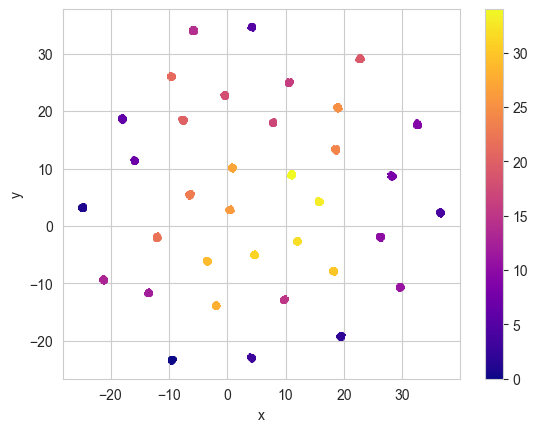

In [10]:
dfBc['x'] = dfBc['reduced'].apply(lambda x: x[0])
dfBc['y'] = dfBc['reduced'].apply(lambda x: x[1])
dfBc.plot.scatter(x='x', y='y', c=dfBc['umap'], cmap="plasma", marker='+')

In [11]:
dfBc.head()

,nodeId,propertyValue,raw,reduced,umap,x,y
0,10000,"[0.14285713, -0.14285713, 0.0, -0.14285713, -0...",29,"[-9.452485, -23.444525]",0,-9.452485,-23.444525
1,10001,"[0.08391814, 0.0, 0.0, 0.0, -0.08391814, 0.083...",3,"[11.223054, 9.033454]",34,11.223054,9.033454
2,10002,"[0.0729325, -0.0729325, 0.0, -0.0729325, -0.07...",12,"[-12.006124, -2.0321438]",22,-12.006124,-2.032144
3,10003,"[0.0, 0.0, 0.0, -0.07124705, -0.07124705, 0.0,...",22,"[-9.543221, 25.963923]",21,-9.543221,25.963923
4,10004,"[0.08391814, 0.0, 0.0, 0.0, -0.08391814, 0.083...",3,"[11.119736, 8.944272]",34,11.119736,8.944272


## Approach B - Layered

### Project

In [12]:
PROJECTION2 = 'ABZ2'
list(map(lambda x: gds.graph.drop(gds.graph.get(x)), list(filter(lambda x: x in [PROJECTION2], gds.graph.list()['graphName']))))
cypher = """
CALL {
    MATCH (a:A)-[r1:FOLLOW]->(b:B)
    RETURN a AS source, labels(a) AS sourceLabel, b AS target, labels(b) AS targetLabel, type(r1) AS relType
    UNION ALL
    MATCH (a:A)-[r1:FOLLOW]->(b:B)-[r2:TRAIT]->(z:Z)
    RETURN b AS source, labels(b) AS sourceLabel, z AS target, labels(z) AS targetLabel, type(r2) AS relType
}
RETURN gds.graph.project($projection_name, source, target,
  {sourceNodeLabels: sourceLabel,
  targetNodeLabels: targetLabel,
  relationshipType: relType},
  {undirectedRelationshipTypes: ['*']})
"""

GB, result = gds.graph.cypher.project(cypher, projection_name=PROJECTION2)
result
gds.graph.list()

,degreeDistribution,graphName,database,databaseLocation,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'min': 1, 'max': 5770, 'p90': 5, 'p999': 5, '...",ABZ,neo4j,local,None,-1,20007,100000,"{'readConcurrency': 4, 'undirectedRelationship...",0.00025,2024-09-05T15:44:56.044497000+00:00,2024-09-05T15:44:56.166233000+00:00,"{'graphProperties': {}, 'nodes': {'A': {}, 'B'...","{'graphProperties': {}, 'nodes': {'A': {}, 'B'..."
1,"{'min': 1, 'max': 5770, 'p90': 5, 'p999': 5, '...",ABZ2,neo4j,local,8831 KiB,9043694,20007,100000,"{'readConcurrency': 4, 'undirectedRelationship...",0.00025,2024-09-05T15:45:20.459370000+00:00,2024-09-05T15:45:20.493056000+00:00,"{'graphProperties': {}, 'nodes': {'A': {}, 'B'...","{'graphProperties': {}, 'nodes': {'A': {}, 'B'..."


### Embed B to Z

In [13]:
EMBEDDING2 = 'fastRP2'
GB = gds.graph.get(PROJECTION2)
gds.fastRP.mutate(GB, iterationWeights=[1.0], embeddingDimension=EMBEDDING_DIMENSION, mutateProperty=EMBEDDING2, nodeLabels=['B', 'Z'], randomSeed=RANDOM_SEED)
dfB2 = gds.graph.nodeProperty.stream(GB, EMBEDDING2, 'B')
dfB2['labels'] = dfB2.apply(lambda x: ['B'], axis='columns')
dfB2.head()

,nodeId,propertyValue,labels
0,10000,"[0.14285713, -0.14285713, 0.0, -0.14285713, -0...",[B]
1,10001,"[0.08391814, 0.0, 0.0, 0.0, -0.08391814, 0.083...",[B]
2,10002,"[0.0729325, -0.0729325, 0.0, -0.0729325, -0.07...",[B]
3,10003,"[0.0, 0.0, 0.0, -0.07124705, -0.07124705, 0.0,...",[B]
4,10004,"[0.08391814, 0.0, 0.0, 0.0, -0.08391814, 0.083...",[B]


### Stream A nodes

Add zero vectors

In [14]:
gds.wcc.mutate(GB, mutateProperty='wcc')
dfA1 = gds.graph.nodeProperty.stream(GB, 'wcc', 'A')
dfA1['propertyValue'] = dfA1.apply(lambda x: list(map(lambda x: 0.0, range(int(EMBEDDING_DIMENSION)))), axis='columns')
dfA1['labels'] = dfA1.apply(lambda x: ['A'], axis='columns')
dfA1.head()

,nodeId,propertyValue,labels
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]


### Stream FOLLOW relationships

In [15]:
relationships = gds.graph.relationships.stream(GB, ['FOLLOW'])
relationships.head()

,sourceNodeId,targetNodeId,relationshipType
0,0,10000,FOLLOW
1,10000,0,FOLLOW
2,1,10001,FOLLOW
3,10001,1,FOLLOW
4,2,10002,FOLLOW


### Construct Graph

In [16]:
NODE_SELF_INFLUENCE = 0.0
PROJECTION3 = 'ABZ3'
list(map(lambda x: gds.graph.drop(gds.graph.get(x)), list(filter(lambda x: x in [PROJECTION3], gds.graph.list()['graphName']))))
GC = gds.graph.construct(PROJECTION3, pd.concat([dfB2, dfA1]), relationships)
gds.graph.list()

Uploading Nodes:   0%|          | 0/20000 [00:00<?, ?Records/s]

Uploading Relationships:   0%|          | 0/20000 [00:00<?, ?Records/s]

/Users/olgarazvenskaia/.env/fastrp-repr/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'TopologyDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'TopologyDataFrame.transpose' instead.
  return bound(*args, **kwds)


,degreeDistribution,graphName,database,databaseLocation,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'min': 1, 'max': 1, 'p90': 1, 'p999': 1, 'p99...",ABZ3,neo4j,none,26 MiB,27752676,20000,20000,"{'readConcurrency': 4, 'jobId': 'ecee9d78-8a3d...",0.00005,2024-09-05T15:45:21.060899000+00:00,2024-09-05T15:45:21.060883000+00:00,"{'graphProperties': {}, 'nodes': {'A': {'prope...","{'graphProperties': {}, 'nodes': {'A': {'prope..."
1,"{'min': 1, 'max': 5770, 'p90': 5, 'p999': 5, '...",ABZ,neo4j,local,None,-1,20007,100000,"{'readConcurrency': 4, 'undirectedRelationship...",0.00025,2024-09-05T15:44:56.044497000+00:00,2024-09-05T15:44:56.166233000+00:00,"{'graphProperties': {}, 'nodes': {'A': {}, 'B'...","{'graphProperties': {}, 'nodes': {'A': {}, 'B'..."
2,"{'min': 1, 'max': 5770, 'p90': 5, 'p999': 5, '...",ABZ2,neo4j,local,None,-1,20007,100000,"{'readConcurrency': 4, 'undirectedRelationship...",0.00025,2024-09-05T15:45:20.459370000+00:00,2024-09-05T15:45:20.656046000+00:00,"{'graphProperties': {}, 'nodes': {'A': {'wcc':...","{'graphProperties': {}, 'nodes': {'A': {'wcc':..."


### Embed combining graph & previously calculated embeddings

In [17]:
EMBEDDING3 = 'fastRP3'
PROPERTY_RATIO = 0.5
gds.fastRP.mutate(GC,
                  embeddingDimension=EMBEDDING_DIMENSION, iterationWeights=[1.0], mutateProperty=EMBEDDING3,
                  nodeSelfInfluence=NODE_SELF_INFLUENCE, propertyRatio=PROPERTY_RATIO, featureProperties=['propertyValue'])

nodePropertiesWritten                                                20000
mutateMillis                                                             0
nodeCount                                                            20000
preProcessingMillis                                                      0
computeMillis                                                           53
configuration            {'mutateProperty': 'fastRP3', 'jobId': 'e04595...
Name: 0, dtype: object

### Stream A Embedding

In [18]:
dfA2 = gds.graph.nodeProperty.stream(GC, EMBEDDING3, 'A')
dfA2.head()
dfA2.describe()

,nodeId
count,10000.00000
mean,4999.50000
std,2886.89568
min,0.00000
25%,2499.75000
50%,4999.50000
75%,7499.25000
max,9999.00000


### Cluster, reduce, cluster

In [19]:
%%time
dfAc = cluster_embedding(dfA2, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), cluster_column='raw')
print("1")
print(dfAc)
dfAc = reduce_embedding(dfAc, umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2))
print("2")
print(dfAc)
dfAc = cluster_embedding(dfAc, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), property_column='reduced', cluster_column='umap')
print("3")
print(dfAc)

1
      nodeId                                      propertyValue  raw
0          0  [0.0, -0.14944443, 0.0, 0.0, -0.14944443, 0.0,...   -1
1          1  [0.0, 0.0, 0.0, 0.0, 0.0, -0.16202636, 0.0, 0....    0
2          2  [-0.15301046, 0.0, 0.0, 0.15301046, 0.0, 0.0, ...   -1
3          3  [0.0, 0.1436631, -0.1436631, -0.1436631, 0.0, ...   -1
4          4  [0.0, 0.0, 0.14729543, -0.14729543, 0.0, 0.0, ...   -1
...      ...                                                ...  ...
9995    9995  [0.0, 0.15048808, 0.15048808, 0.0, 0.0, 0.1504...    0
9996    9996  [0.0, 0.15708804, 0.15708804, 0.0, -0.15708804...    0
9997    9997  [0.0, 0.0, -0.15447322, 0.0, 0.0, 0.0, 0.0, 0....   -1
9998    9998  [0.0, 0.1585051, 0.0, 0.0, -0.1585051, -0.1585...   -1
9999    9999  [-0.14719158, 0.14719158, 0.0, -0.14719158, 0....    0

[10000 rows x 3 columns]
2
      nodeId                                      propertyValue  raw  \
0          0  [0.0, -0.14944443, 0.0, 0.0, -0.14944443, 0.0,...   -1  

### Raw Clusters

In [20]:
dfAc['raw'].value_counts()

raw
-1    5162
 0    4801
 1      37
Name: count, dtype: int64

### UMAP Clusters

In [21]:
dfAc['umap'].value_counts()

umap
25    310
8     308
1     307
0     305
18    301
3     299
12    297
19    296
21    295
11    294
2     294
27    293
4     293
9     291
16    290
31    290
26    288
17    288
24    287
33    286
32    284
10    283
28    283
7     282
14    282
15    281
5     278
20    276
23    271
13    269
34    268
6     266
22    260
29    257
30    248
Name: count, dtype: int64

<Axes: xlabel='x', ylabel='y'>

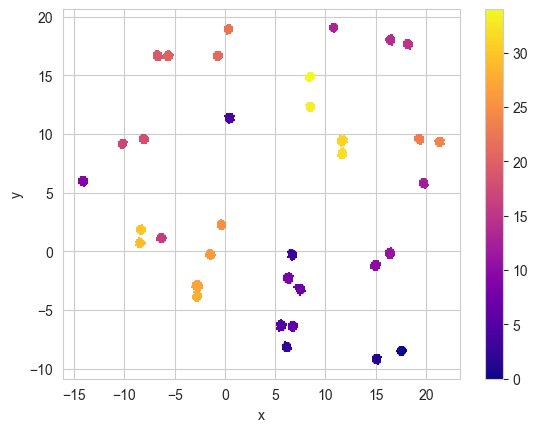

In [22]:
dfAc['x'] = dfAc['reduced'].apply(lambda x: x[0])
dfAc['y'] = dfAc['reduced'].apply(lambda x: x[1])
dfAc.plot.scatter(x='x', y='y', c=dfAc['umap'], cmap="plasma", marker='+')

In [23]:
relmap = dict(map(lambda x: (x['sourceNodeId'], x['targetNodeId']), relationships.to_dict(orient='records')))
dfAc['FOLLOW'] = dfAc.apply(lambda x: relmap[x['nodeId']], axis=1)
dfAc.head()

,nodeId,propertyValue,raw,reduced,umap,x,y,FOLLOW
0,0,"[0.0, -0.14944443, 0.0, 0.0, -0.14944443, 0.0,...",-1,"[5.452428, -6.2435846]",5,5.452428,-6.243585,10000
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.16202636, 0.0, 0....",0,"[17.520271, -8.520855]",0,17.520271,-8.520855,10001
2,2,"[-0.15301046, 0.0, 0.0, 0.15301046, 0.0, 0.0, ...",-1,"[6.6592703, -0.15246892]",3,6.659270,-0.152469,10002
3,3,"[0.0, 0.1436631, -0.1436631, -0.1436631, 0.0, ...",-1,"[8.48929, 14.80374]",34,8.489290,14.803740,10003
4,4,"[0.0, 0.0, 0.14729543, -0.14729543, 0.0, 0.0, ...",-1,"[17.710619, -8.439461]",0,17.710619,-8.439461,10004


## Compare - Ovelap between clusters

The cluster membership of B nodes (B->Z embedding) should overlap with the cluster membership of the A node (A->B property embedding).

Maximal overlap is when the heatmap below has a red diagonal.

This is observed when propertyRatio = 0.5 (or exactly 1.0). Deviation from 0.5 toward 0.0 or 1.0 results in an embedding that carries little information from the original property embeddings (the cluster ovelap breaks down).

       25     8      1      0      18     3      12     19     21     11  ...  \
6   100.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1     0.0  100.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
10    0.0    0.0  100.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
34    0.0    0.0    0.0  100.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
25    0.0    0.0    0.0    0.0  100.0    0.0    0.0    0.0    0.0    0.0  ...   
22    0.0    0.0    0.0    0.0    0.0  100.0    0.0    0.0    0.0    0.0  ...   
8     0.0    0.0    0.0    0.0    0.0    0.0  100.0    0.0    0.0    0.0  ...   
9     0.0    0.0    0.0    0.0    0.0    0.0    0.0  100.0    0.0    0.0  ...   
24    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  100.0    0.0  ...   
13    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
33    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  100.0  ...   
28    0.0    0.0    0.0    0

<Axes: >

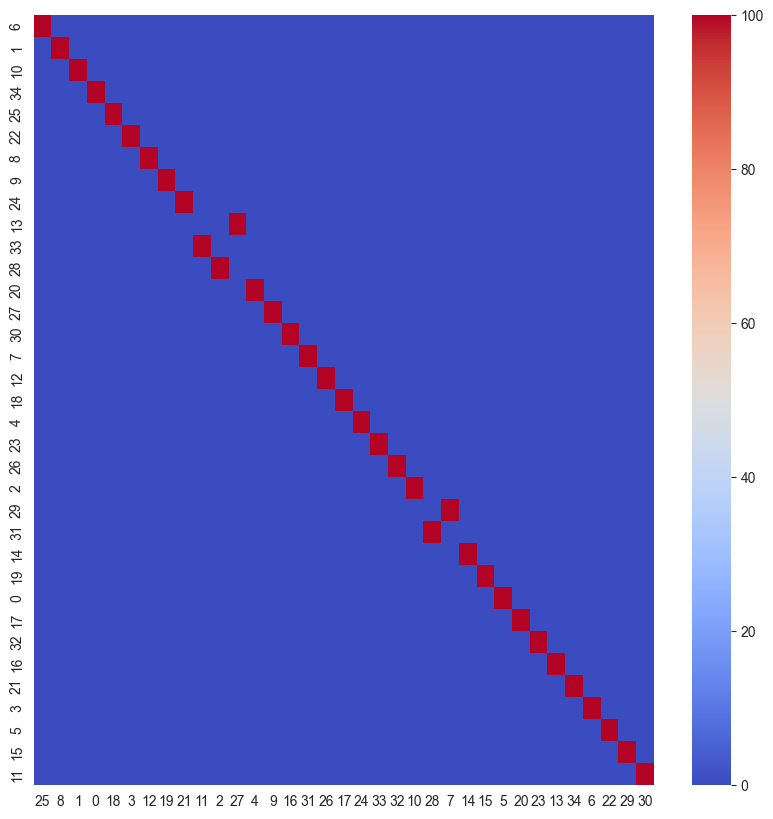

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

I = {}
for x in dfAc['umap'].value_counts().index:
  I[x] = {}
  for y in dfBc['umap'].value_counts().index:
    sA = set(dfAc[dfAc['umap'] == x]['FOLLOW'])
    sB = set(dfBc[dfBc['umap'] == y]['nodeId'])
    I[x][y] = 100 * len(sA & sB) / len(sA | sB)

print(pd.DataFrame(I))
fig, ax = plt.subplots(figsize=(10, 10))
#sns.heatmap(pd.DataFrame(I), cmap='coolwarm', annot=True, fmt=".0f")
sns.heatmap(pd.DataFrame(I), cmap='coolwarm')

In [25]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, homogeneity_completeness_v_measure

# Example cluster assignments from two algorithms
labels_algorithm_1 = dfAc['umap']
labels_algorithm_2 = dfBc['umap']

# Adjusted Rand Index
ari = adjusted_rand_score(labels_algorithm_1, labels_algorithm_2)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

# Normalized Mutual Information
nmi = normalized_mutual_info_score(labels_algorithm_1, labels_algorithm_2)
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")

# Fowlkes-Mallows Index
fmi = fowlkes_mallows_score(labels_algorithm_1, labels_algorithm_2)
print(f"Fowlkes-Mallows Index (FMI): {fmi:.3f}")

# Homogeneity, Completeness, and V-Measure
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(labels_algorithm_1, labels_algorithm_2)
print(f"Homogeneity: {homogeneity:.3f}")
print(f"Completeness: {completeness:.3f}")
print(f"V-Measure: {v_measure:.3f}")


Adjusted Rand Index (ARI): 1.000
Normalized Mutual Information (NMI): 1.000
Fowlkes-Mallows Index (FMI): 1.000
Homogeneity: 1.000
Completeness: 1.000
V-Measure: 1.000


## Close

In [26]:
#gds.graph.drop(G)
#gds.close()
#n4j.close()
#driver.close()